# Demonstration of Image Comparison
This notebook discusses basics of registration, resampling, and image comparison.

This demo is a jupyter notebook, i.e. intended to be run step by step.

Author: Eric Einspänner
<br>
Contributor: Nastaran Takmilhomayouni
First version: 6th of July 2023


Copyright 2023 Clinic of Neuroradiology, Magdeburg, Germany

License: Apache-2.0

## Table of contents
1. [Initial set-up](#Initial-Set-Up)
2. [Load image/volume](#Load-the-Image/Volume)
3. [Translation](#Translation)
4. [Rotation](#Rotations)
5. [Affine Transformation](#Affine-Transformation)
6. [Resampling](#Resampling)
7. [Interpolation](#Interpolation)
8. [MAE](#Mean-Absolute-Error-MAE)
9. [SSIM](#Structural-Similarity-SSIM)
10. [IoU](#Intersection-of-The-Union-IOU)
11. [Testing group differences](#Testing-Group-Differences)
12. [Normalizing metrics](#Normalizing-Metrics)

## Initial Set-Up

In [1]:
# Make sure figures appears inline and animations works
# Edit this to ""%matplotlib notebook" when using the "classic" jupyter notebook interface
%matplotlib widget


In [2]:
# Initial imports etc
import imageio
import pandas as pd
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from Utilities.downloaddata import fetch_data as fdata
import SimpleITK as sitk
import Utilities.gui

In [3]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')    
    plt.tight_layout()
    plt.show()

## Load the Image/Volume

In [5]:
# Load the directory (volume)
#folder_path = 'C:/Users/einspaen/Downloads/Biomedical-Image-Analysis-in-Python-master/Biomedical-Image-Analysis-in-Python-master/Data/Brain/SE000001/MR000000'
folder_path = 'Data/SE000001/MR000000'

vol = imageio.volread(folder_path)

# save the middle slice as separat image
im = vol[13,:,:]

Reading DICOM (examining files): 1/27 files (3.7%27/27 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 27/27  (100.0%)


## Translation
In this chapter, we'll leverage data use data from the Open Access Series of Imaging Studies to compare the brains of different populations: young and old, male and female, healthy and diseased.

To start, center a single slice of a 3D brain volume (im). First, find the center point in the image array and the center of mass of the brain. Then, translate the image to the center.

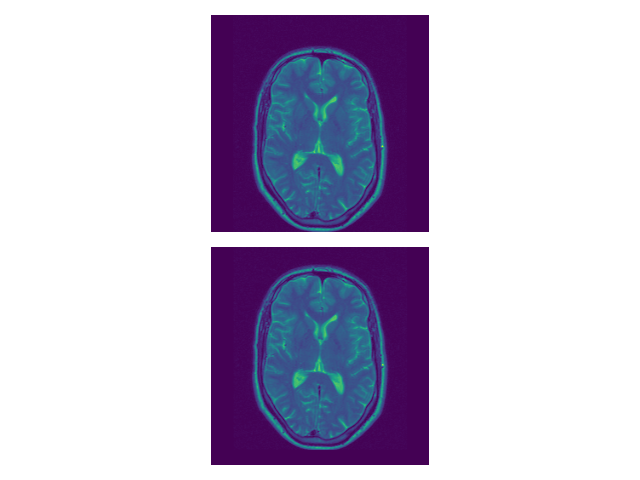

In [6]:
# Find image center of mass
com = ndi.center_of_mass(im)

# Calculate amount of shift needed
d0 = 128 - com[0]
d1 = 128 - com[1]

# Translate the brain towards the center
xfm = ndi.shift(im, shift=(d0, d1))

# Plot the original and adjusted images
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].imshow(im)
axes[1].imshow(xfm)
format_and_render_plot()

## Rotations
In cases where an object is angled or flipped, the image can be rotated. Using `ndi.rotate()`, the image is rotated from its center by the specified degrees from the right horizontal axis.

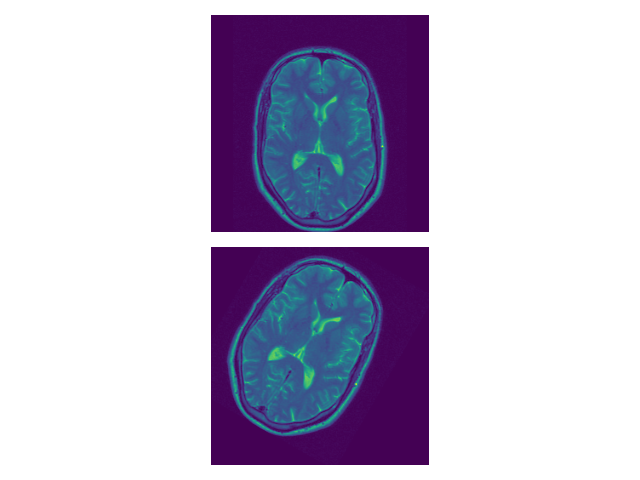

In [7]:
# Shift the image towards the center
xfm = ndi.shift(im, shift=(-20, -20))

# Rotate the shifted image
xfm = ndi.rotate(xfm, angle=-30, reshape=False)

# Plot the original and transformed images
fig, axes = plt.subplots(2, 1)
axes[0].imshow(im)
axes[1].imshow(xfm)
format_and_render_plot()

## Affine Transformation
An affine transformation matrix provides directions for up to four types of changes: translating, rotating, rescaling and shearing. The elements of the matrix map the coordinates from the input array to the output.

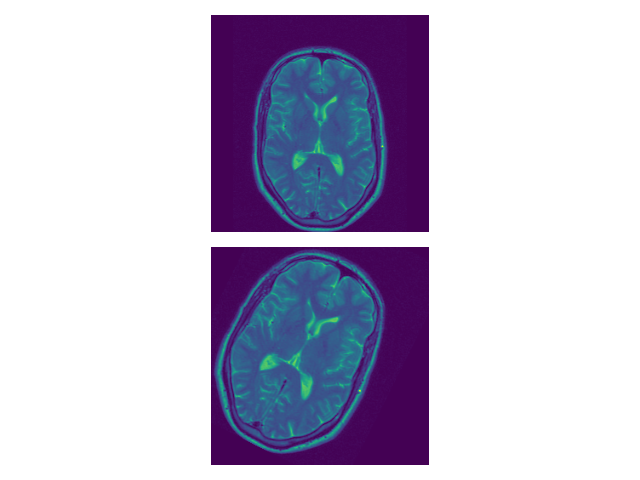

In [8]:
mat = np.array([[0.8, -0.4, 90], [0.4, 0.8, -6.0], [0, 0, 1]])
xfm = ndi.affine_transform(im, mat)
plt.imshow(xfm)
plt.show()

## Resampling
Images can be collected in a variety of shapes and sizes. Resampling is a useful tool when these shapes need to be made consistent. Two common applications are:

- Downsampling: combining pixel data to decrease size
- Upsampling: distributing pixel data to increase size

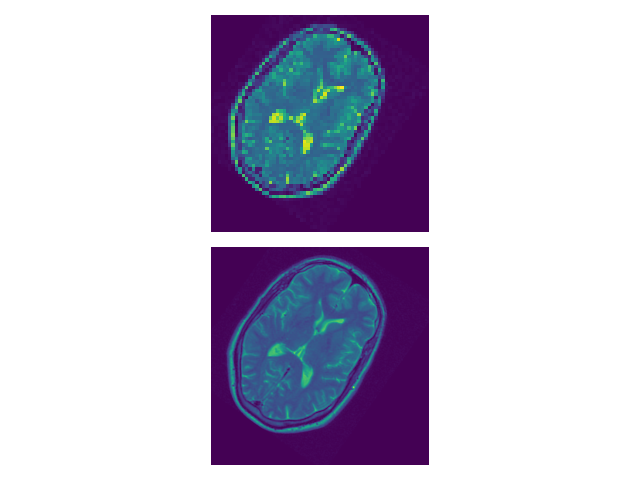

In [9]:
# Center and level image
xfm = ndi.shift(im, shift=(-20, -20))
xfm = ndi.rotate(xfm, angle=-35, reshape=False)

# Resample image
im_dn = ndi.zoom(xfm, zoom=0.25)
im_up = ndi.zoom(xfm, zoom=4.00)

# Plot the images
fig, axes = plt.subplots(2, 1)
axes[0].imshow(im_dn)
axes[1].imshow(im_up)
format_and_render_plot()

## Interpolation
Interpolation is how new pixel intensities are estimated when an image transformation is applied. It is implemented in SciPy using sets of spline functions.

Editing the interpolation `order` when using a function such as `ndi.zoom()` modifies the resulting estimate: higher orders provide more flexible estimates but take longer to compute.

Original shape: (256, 256)
Upsampled shape: (1024, 1024)


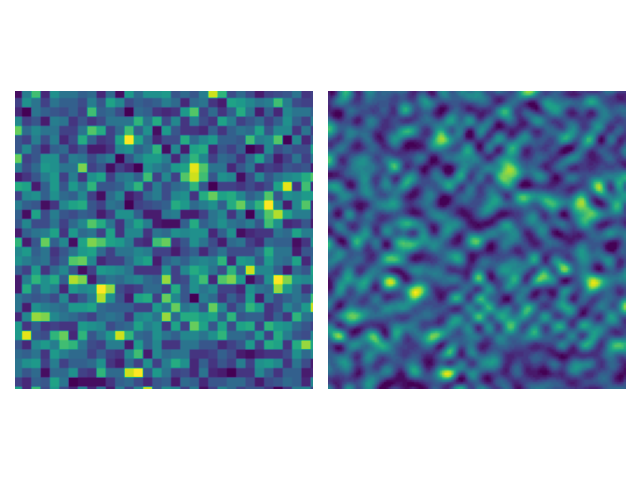

In [10]:
# Upsample "im" by a factor of 4
up0 = ndi.zoom(im, zoom=512/128, order=0)
up5 = ndi.zoom(im, zoom=512/128, order=5)

# Print original and new shape
print('Original shape:', im.shape)
print('Upsampled shape:', up5.shape)

# Plot close-ups of the new images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(up0[128:256, 128:256])
axes[1].imshow(up5[128:256, 128:256])
format_and_render_plot()

## Mean Absolute Error (MAE)
Cost functions and objective functions output a single value that summarizes how well two images match.

The MAE, for example, summarizes intensity differences between two images, with higher values indicating greater divergence.

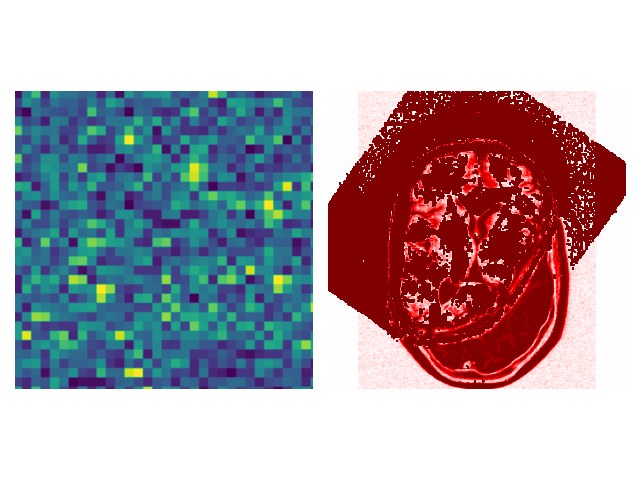

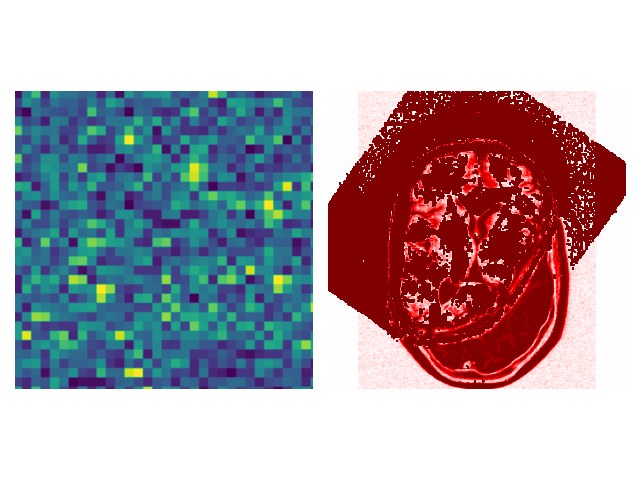

MAE: 25958.017471313477


In [11]:
# Load the dcm file (image)
im1 = im
im2 = xfm

# Calculate image difference
err = im1 - im2

# Plot the difference
plt.imshow(err, cmap='seismic', vmin=-200, vmax=200)
format_and_render_plot()

# Calculate absolute image difference
abs_err = np.absolute(im1 - im2)

# Plot the difference
plt.imshow(abs_err, cmap='seismic', vmin=-200, vmax=200)
format_and_render_plot()

# Calculate mean absolute error
mean_abs_err = np.mean(np.abs(im1 - im2))
print('MAE:', mean_abs_err)

## Structural Similarity (SSIM)

## Intersection of The Union (IoU)

Another cost function is the IoU. The IoU is the number of pixels filled in both images (the intersection) out of the number of pixels filled in either image (the union).

In [12]:
def intersection_of_union(im1, im2):
    i = np.logical_and(im1, im2)
    u = np.logical_or(im1, im2)
    return i.sum() / u.sum()

In [13]:
# Try some other paramters by yourself
xfm = ndi.shift(im1, shift=(-10, -10))
xfm = ndi.rotate(xfm, angle=-15, reshape=False)
intersection_of_union(xfm, im2)

0.8140215355805244

## Testing Group Differences
Once measures have been extracted, double-check for dependencies within your data. This is especially true if any image parameters (sampling rate, field of view) might differ between subjects, or you pull multiple measures from a single image.

For the final exercises, we have combined demographic and brain volume measures into a pandas DataFrame (df).

In [ ]:
# I have written that(Nastaran)
# If you run the following cell, you will see an error: 
# NameError: name 'df' is not defined
# Following this link:
#https://campus.datacamp.com/courses/biomedical-image-analysis-in-python/image-comparison?ex=12
# df is OASIS dataframe created here:
#https://campus.datacamp.com/courses/biomedical-image-analysis-in-python/image-comparison?ex=11

In [14]:
# Print random sample of rows
print(df.sample(3))

# Print prevalence of Alzheimer's Disease
print(df.alzheimers.value_counts())

# Print a correlation table
print(df.corr())

NameError: name 'df' is not defined

Let's test the hypothesis that Alzheimer's Disease is characterized by reduced brain volume.

We can perform a two-sample t-test between the brain volumes of elderly adults with and without Alzheimer's Disease. In this case, the two population samples are independent from each other because they are all separate subjects.

In [ ]:
# Import independent two-sample t-test
from scipy.stats import ttest_ind

# Select data from "alzheimers" and "typical" groups
brain_alz = df.loc[df.alzheimers == True, 'brain_vol']
brain_typ = df.loc[df.alzheimers == False, 'brain_vol']

# Perform t-test of "alz" > "typ"
results = ttest_ind(brain_alz, brain_typ)
print('t = ', results.statistic)
print('p = ', results.pvalue)

# Show boxplot of brain_vol differences
df.boxplot(column='brain_vol', by='alzheimers')
plt.show()

## Normalizing Metrics
We previously saw that there was not a significant difference between the brain volumes of elderly individuals with and without Alzheimer's Disease.

But could a correlated measure, such as "skull volume" be masking the differences?

In [ ]:
# Adjust `brain_vol` by `skull_vol`
df['adj_brain_vol'] = df.brain_vol / df.skull_vol

# Select brain measures by group
brain_alz = df.loc[df.alzheimers == True, 'adj_brain_vol']
brain_typ = df.loc[df.alzheimers == False, 'adj_brain_vol']

# Evaluate null hypothesis
results = ttest_ind(brain_alz, brain_typ)

## Combining Two Images

There are a variety of ways we can overlay two (partially) overlapping images onto each other. The common approaches include:

    1- Use of alpha blending.
    2- Use of a checkerboard pattern with the pixel values in adjacent squares/boxes taken from each of the images.
    3- When the pixel values are scalars (gray scale images), combine the two images in different channels, resulting in a           color image.

We will start by loading two images whose content luckily overlaps in physical space. Before we can combine the two, we need to resample one of them so that they both occupy the same spatial region. In addition we should also rescale the intensities so that they occupy the same range. In our case we will map them to [0,255], based on the desired windowing.

Fetching training_001_mr_T1.mha
Fetching training_001_ct.mha


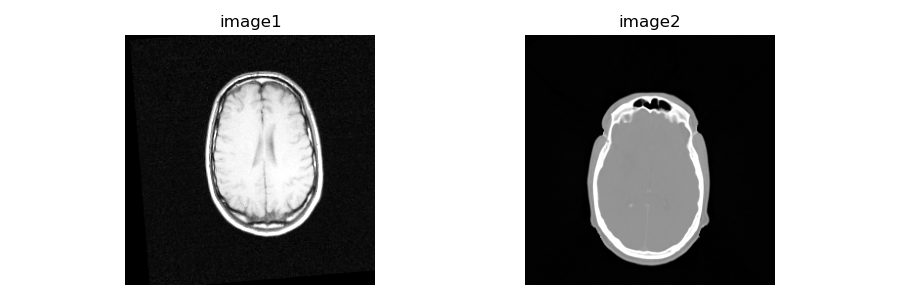

In [15]:
img1 = sitk.ReadImage(fdata("training_001_mr_T1.mha"))
img2_original = sitk.ReadImage(fdata("training_001_ct.mha"))
img2 = sitk.Resample(img2_original, img1)

# Obtain foreground masks for the two images using Otsu thresholding, we use these later on.
msk1 = sitk.OtsuThreshold(img1,0,1)
msk2 = sitk.OtsuThreshold(img2,0,1)

Utilities.gui.MultiImageDisplay(image_list = [img1, img2],                   
                      title_list = ['image1', 'image2'],
                      figure_size=(9,3));

In [16]:
# Having identified the desired intensity range for each of the 
# images using the GUI above, we use these values to perform intensity windowing and map the intensity values
# to [0,255] and cast to 8-bit unsigned int
img1_255 = sitk.Cast(sitk.IntensityWindowing(img1, windowMinimum=2, windowMaximum=657, 
                                             outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)
img2_255 = sitk.Cast(sitk.IntensityWindowing(img2, windowMinimum=-1018, windowMaximum=1126, 
                                             outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)